# ezSegmenter

#### This segmentation tool enables creation of masks for objects not easily picked up by primary cell segmentation methods on multiplexed imaging data.
#### In addition this tool can be used to create composites of channels as well as merge object masks with cell masks.

## 0: Import packages and download example dataset (if desired)

Here we are using the example data located in `/data/example_dataset/input_data`. To modify this notebook to run using your own data, simply change `base_dir` to point to your own sub-directory within the data folder.

* `base_dir`: the path to all of your imaging data. This directory will contain all of the data generated by this notebook.

In [37]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
%autoreload 2

In [169]:
import pathlib
from ark.segmentation.ez_seg import (
    create_object_masks,
    ez_seg_display,
    merge_masks_seq,
    composite_builder,
    relabel_all_masks,
)
from alpineer import io_utils, load_utils
from ark.utils import example_dataset
from ark.segmentation import marker_quantification

## 1: set file paths and parameters

In [142]:
# set up the base directory - all base image data, segmentation masks, and cell tables should be found in this parent directory.
import os


base_dir = "/Volumes/Shared/Bryan Cannon/ez_ark_testing_data/"

os.path.exists(base_dir)

True

In [143]:
# set up file paths
import os

tiff_dir = os.path.join(base_dir, "TIFs")
segmentation_dir = os.path.join(base_dir, "segmentation")
ez_seg_dir = os.path.join(segmentation_dir, "ez_seg")

ez_table_dir = os.path.join(ez_seg_dir, "ez_table")
ez_input_dir = os.path.join(ez_seg_dir, "ez_input")
ez_output_dir = os.path.join(ez_seg_dir, "ez_output")
ez_object_dir = os.path.join(ez_seg_dir, "ez_object")
ez_visualization_dir = os.path.join(ez_seg_dir, "ez_visualization")
composite_dir = os.path.join(ez_seg_dir, "composites")

In [144]:
# create directories if do not exist
for directory in [
    base_dir,
    segmentation_dir,
    ez_seg_dir,
    tiff_dir,
    ez_input_dir,
    ez_object_dir,
    ez_output_dir,
    ez_table_dir,
    ez_visualization_dir,
]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [145]:
# validate paths
io_utils.validate_paths(
    [
        base_dir,
        segmentation_dir,
        ez_seg_dir,
        ez_object_dir,
        tiff_dir,
        ez_input_dir,
        ez_output_dir,
        ez_table_dir,
        ez_visualization_dir,
    ]
)

### Compute and filter fov paths

In [147]:
# either get all fovs in the folder...
fovs = io_utils.list_folders(tiff_dir)

# ... or optionally, select a specific set of fovs manually
# fovs = ["fov0", "fov1"]
print(fovs)

['fov-90-scan-1', 'fov-91-scan-1', 'fov-92-scan-1', 'fov-93-scan-1', 'fov-94-scan-1', 'fov-95-scan-1', 'fov-96-scan-1', 'fov-97-scan-1', 'fov-98-scan-1', 'fov-99-scan-1']


## 2. Composite Builder

#### Set composite paths, test FOV

In [45]:
# What would you like to name your composite image
composite_name = "composite_microglia"

In [47]:
# What channels would you like to add together?
to_add = ["Iba1 ", "CD45 "]
# What channels would you like to subtract?
to_subtract = ["HistoneH3Lyo", "Background"]

#### Create your composite channel.
Specify image_type ("signal" or "pixel_clustered"), and composite_method ("total" or "binary") below.

In [48]:
image_type = "signal"
composite_method = "total"

In [49]:
fov = fovs

In [50]:
# Run composite builder
composite_builder(
    data_dir=tiff_dir,
    fov_list=fov,
    images_to_add=to_add,
    images_to_subtract=to_subtract,
    image_type=image_type,
    composite_name=composite_name,
    composite_directory=composite_dir,
    composite_method=composite_method,
)

/Volumes/Shared/Bryan Cannon/ez_ark_testing_data/segmentation/ez_seg/composites/fov-90-scan-1/composite_microglia.tiff


/Users/bryjc/Library/CloudStorage/GoogleDrive-bryjc@stanford.edu/My Drive/Software/ark-analysis/src/ark/segmentation/ez_seg/ez_seg_display.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


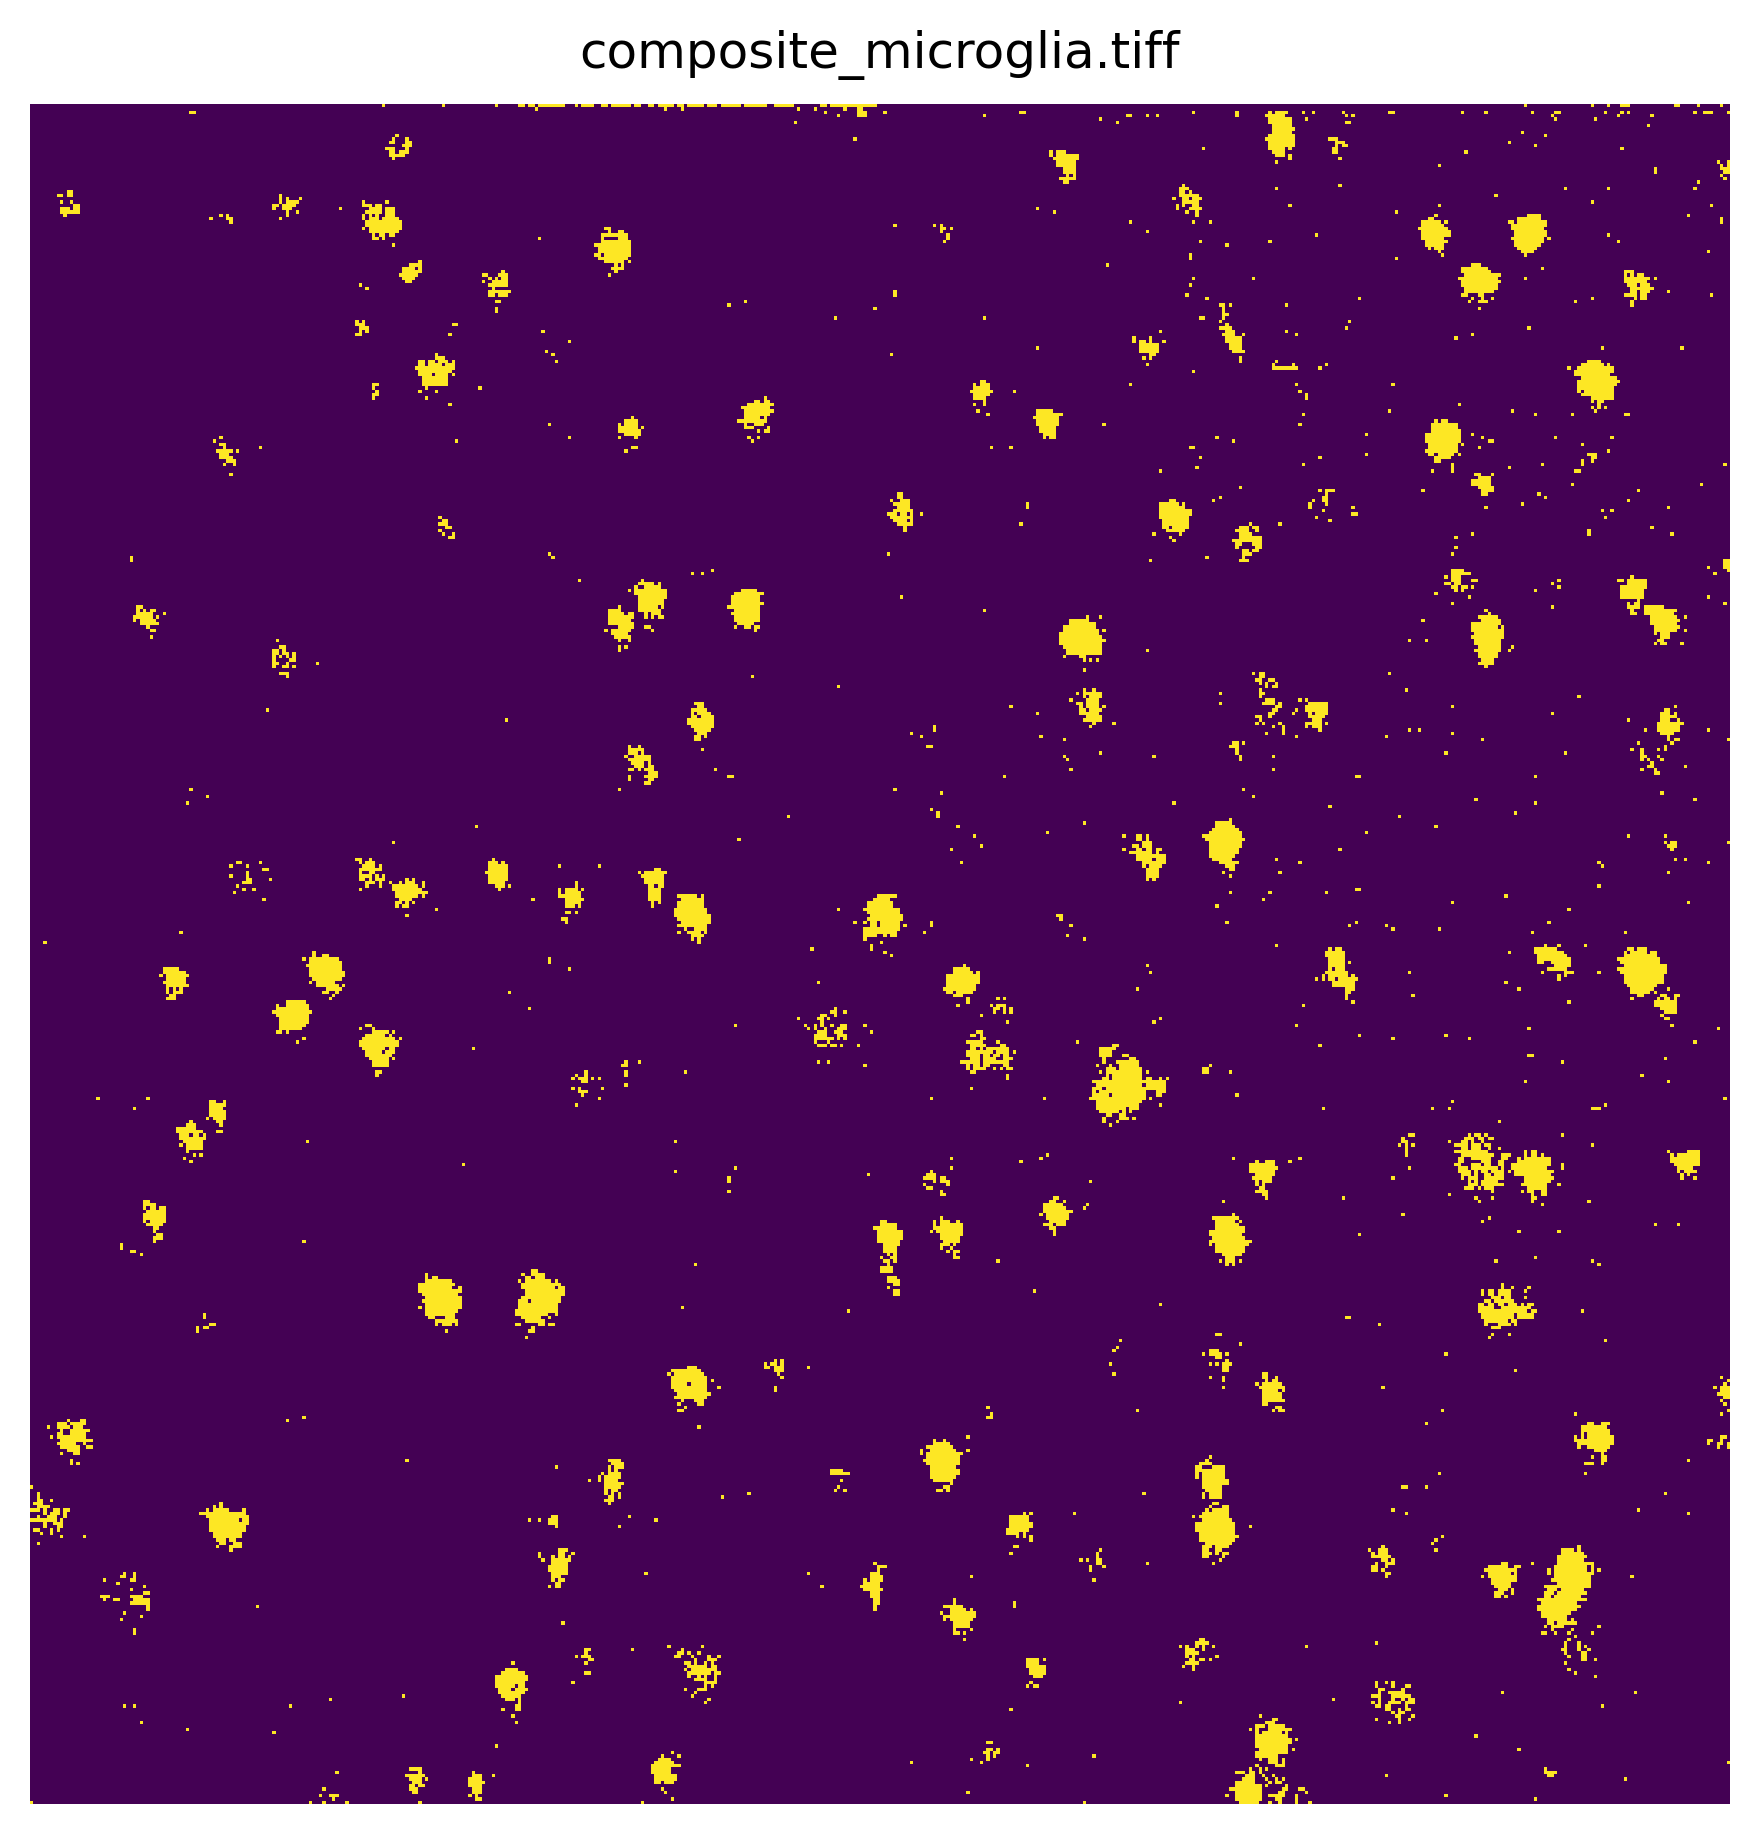

In [51]:
# Specify which FoV you'd like to see for visual testing purposes.
test_fov_name = "fov-90-scan-1"


# This should be the composite name you specified above
composite_name = "composite_microglia"
# Show test composite image

composite_image_path = os.path.join(
    composite_dir, test_fov_name, composite_name + ".tiff"
)
print(composite_image_path)

ez_seg_display.display_channel_image(composite_image_path)

## 3. Create Object Masks

#### Create your object segmentation masks.
Here you will input which channel you would like as a base for segmenting single object masks.

Additionally, set the following segmentation parameters below:

- `channel_to_segment`: The name of the channel you wish to segment on.
- `mask_name`: The name you want to label these masks as, e.g. `"plaques"` or `"microglia-projections"`
- `object_shape`: The general shape of the object, can be either `"blob"` or `"projection"`
- `blur`: The standard deviation for the Gaussian kernel to blur the image.
- `threshold`: The global threshold value for image thresholding if desired.
- `hole_size`: Sets the lower bound for an object's area to be considered as an object, for any area smaller than `hole_size` those holes are closed.
- `fov_size`: The length of one side of your FOV in μm
- `min_pixels`: The minimum number of pixels required in a segmented object
- `max_pixels`: The maximum number of pixels required in a segmented object


In [172]:
channel_to_segment = "Iba1 "
mask_name = "Iba1_test_mask"

fov_name = fovs
object_shape = "projection"
blur = 1
threshold = None
hole_size = None
fov_size = 400
min_pixels = 100
max_pixels = 100000

In [181]:
# Input parameters and segment images.
create_object_masks(
    image_dir=tiff_dir,
    fov_list=fov_name,
    channel_to_segment=channel_to_segment,
    object_dir=ez_object_dir,
    mask_name=mask_name,
    object_shape_type=object_shape,
    sigma=blur,
    thresh=threshold,
    hole_size=hole_size,
    fov_dim=fov_size,
    min_object_area=min_pixels,
    max_object_area=max_pixels,
)

In [184]:
# Specify which segmented FoV you'd like to see for visual testing purposes.

test_fov_name = "fov-93-scan-1"
# Show test segmentation image
channel_to_segment_path = os.path.join(
    ez_object_dir, test_fov_name, f"{channel_to_segment}.tiff"
)

mask_path = os.path.join(ez_object_dir, test_fov_name, f"{mask_name}.tiff")
ez_seg_display.overlay_mask_outlines(channel_to_segment_path, mask_path)

FileNotFoundError: The file/path, Iba1 .tiff, could not be found...

## 5. Mask Merger

Merging enables connecting traditional circular or oval shaped nucelar-based cell masks with anuclear cell projections (e.g. microglia arms with microglia soma)
**Note:** Requires the Deepcell outputs from `1_Segment_Image_Data.ipynb`.

#### Here you can merge object segmentation masks with cell masks (or any other type of mask).
Here you will provide a list of what objects you would like to merge with previously segmented cell masks (or other base mask).

**LIST ORDER IMPORTANT**: The first mask listed will be merged first, the second mask with cells not merged during the first merge, etc.

Additionally, set the percent area of an object that needs to be overlapping onto a cell mask to get merged.

In [85]:
fov = fovs[0]

In [ ]:
# Input path
curr_object_mask = ez_object_dir + fov 
# List of object masks to merge to the base (cell) image.
merge_masks_list = ["microglia-arms", "astrocyte-arms", "neuropil"]
# Value (1-100) required for an object mask to be merged into a cell mask.
percent_overlap = 70

In [ ]:
# Decide here if you want a single mask combining all cells and objects found in merge_mask_list (True) or a merged mask saved for each cell and object type (False).
fully_combined_masks = True

In [ ]:
merge_masks_seq(
    object_list=["composite_b", "composite_a"],
    object_mask_dir=ez_seg_dir,
    cell_mask_path=curr_object_mask,
    overlap=percent_overlap,
    save_path=composite_dir,
)

In [ ]:
segmentation_mask

In [ ]:
# # Specify which segmented FoV you'd like to see for visual testing purposes.
test_FOV_name = ""
# this should take the base path from earlier, the composite path, the test FoV name, and the composite name without user input.
ez_seg_test_masks = ""
# Show test composite image
ez_seg_display.multiple_mask_displays(merge_masks_list, segmentation_mask)

## 6. Relabel all masks

Run this step to ensure all mask ids across all segmentations (deepcell, ez, or other inputs) are relabeled from 1 to n total masks.
Need to run before merging if applying merge step.

In [83]:
# Enter the root directory where all masks are located.
# May need to adjust this so masks and channel tiffs are both not imported by renumber masks.
root_mask_dir = ez_seg_dir

In [84]:
# Run this cell to relabel all masks in all folders.
relabel_all_masks.renumber_masks(root_mask_folder)

## 7. Generate single cell and/or object expression table

In [ ]:
# set to True to bypass expensive cell or object property calculations
# only cell or object label, size, and centroid will be extracted if True
fast_extraction = False

# If you want to give your cell label an alternative name (e.g. plaques.csv), write that name below, otherwise leave as "cell".
table_name = "cell"

# set to True to add nuclear cell properties to the expression matrix
nuclear_counts = True

For a full list of features extracted, please refer to the cell table section of: https://ark-analysis.readthedocs.io/en/latest/_rtd/data_types.html

In [ ]:
# now extract the segmented imaging data to create normalized and transformed expression matrices
# note that if you're loading your own dataset, please make sure all the imaging data is in the same folder
# with each fov given its own folder and all fovs having the same channels


# combine any merged objects, any remaining unmerged cell-masks and any remaining object masks which
# were not included.
(
    cell_table_size_normalized,
    cell_table_arcsinh_transformed,
) = marker_quantification.generate_output_dire_cell_table(
    segmentation_dir=root_mask_dir,
    tiff_dir=tiff_dir,
    img_sub_folder=None,
    fovs=fovs,
    batch_size=5,
    nuclear_counts=nuclear_counts,
    fast_extraction=fast_extraction,
)

In [ ]:
cell_table_dir = os.path.join(root_mask_dir, "cell_table")

In [ ]:
# Set the compression level if desired, ZSTD compression can offer up to a 60-70% reduction in file size.
# NOTE: Compressed `csv` files cannot be opened in Excel. They must be uncompressed beforehand.
compression = None

# Uncomment the line below to allow for compressed `csv` files.
# compression = {"method": "zstd", "level": 3}

cell_table_size_normalized.to_csv(
    os.path.join(cell_table_dir, table_name + "_table_size_normalized.csv"),
    compression=compression,
    index=False,
)
cell_table_arcsinh_transformed.to_csv(
    os.path.join(cell_table_dir, table_name + "_table_arcsinh_transformed.csv"),
    compression=compression,
    index=False,
)

## End - Cell & Object Masks and Table have been saved